## ANLP Assignment 2: Text Generation
### Shuying Piao,  id: a1912828

In [1]:
import pandas as pd

import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


# 1. Reading dataset and initial pre-processing

In [2]:
# Load and process a single dataset (train or test): expand 'ratings', retain other fields, and set 'review_id' as index.
def prepare_dataset(data_path):
    df = pd.read_json(data_path, lines=True)
    df = df.rename(columns={'id': 'review_id'})
    
    ratings_df = df['ratings'].apply(pd.Series)
    extra_columns = [col for col in df.columns if col not in ['text', 'title', 'ratings']]
    
    processed_df = pd.concat([ratings_df, df[extra_columns],df[['text']]], axis=1)
    processed_df = processed_df.set_index('review_id')
    
    return processed_df

In [3]:
train_df= prepare_dataset('hotel_reviews_train.JSON')
test_df= prepare_dataset('hotel_reviews_test.JSON')
train_df.head(3)

,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access),author,date_stayed,offering_id,num_helpful_votes,date,via_mobile,text
review_id,,,,,,,,,,,,,,,,
140716137,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,False,First of all we got there and they didn't have...
114807323,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,False,Found Racist graffiti in the room. Request to ...
84805430,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,False,Close to Union Square - hotel is a bit of a ma...


In [4]:
# View basic info of the training set: column data types, non-null counts
print("\nTrain Data Info:")
train_df.info()

# View basic info of the test set: column data types, non-null counts
print("\nTest Data Info:")
test_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 140716137 to 145539000
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   service                                 21550 non-null  float64       
 1   cleanliness                             21545 non-null  float64       
 2   overall                                 24000 non-null  float64       
 3   value                                   21547 non-null  float64       
 4   location                                18983 non-null  float64       
 5   sleep_quality                           14185 non-null  float64       
 6   rooms                                   20000 non-null  float64       
 7   check_in_front_desk                     2909 non-null   float64       
 8   business_service_(e_g_internet_access)  1959 non-null   float64       
 9   author                   

In [5]:
# Define a cleaning function for the target review text
import re

def clean_text_for_generation(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Convert to lowercase for easier word vector matching
    text = re.sub(r'<.*?>', '', text)  # Remove any HTML tags
    text = re.sub(r'[^\x00-\x7F]+', '', text)   # Remove non-ASCII characters (emoji, non-English characters)
    text = re.sub(r'[^a-z0-9.,!?\'\";:\-\s]', '', text)  #keep English chars & punctuation
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace by replacing multiple spaces with a single space
    return text.strip()


train_df['text'] = train_df['text'].apply(clean_text_for_generation)
test_df['text'] = test_df['text'].apply(clean_text_for_generation)

Given that the core task of this assignment is to predict a customer’s review based on the overall rating and aspect-level numerical ratings, the first step in this phase is to expand the ratings field into separate rating dimensions. This facilitates both exploratory data analysis (EDA) and structured model input.

In addition to the ratings, I retained all other metadata fields (such as author, date_stayed, offering_id, etc.), as they may provide meaningful contextual signals for the generation task. Rather than removing records with missing values, I chose to dynamically skip missing fields during input prompt construction. This approach preserves as much useful information as possible while avoiding unnecessary data loss.

To further improve the consistency and quality of the review generation task, I applied text normalization to the text field. The cleaning process includes converting text to lowercase, removing non-ASCII characters, HTML tags, and redundant spaces. This ensures a cleaner and more consistent target output for training the model effectively.

# 2. Exploratory Data Analysis (EDA)

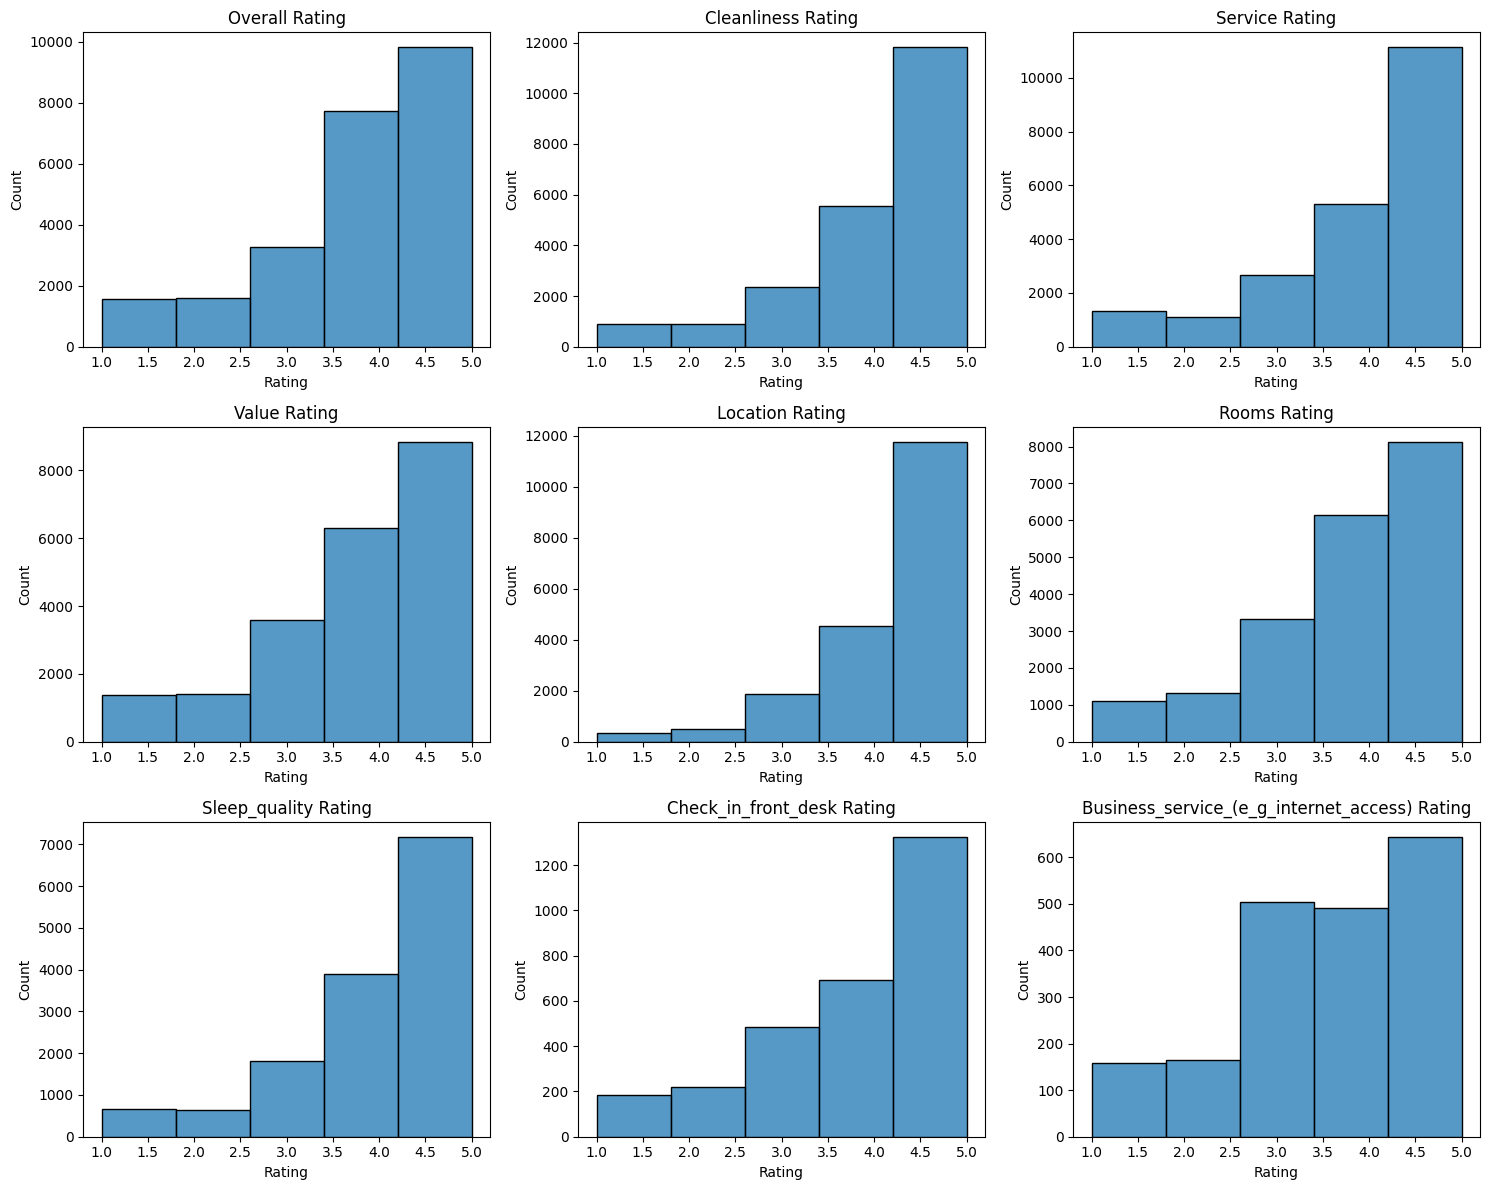

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define rating-related fields
rating_fields = ['overall', 'cleanliness', 'service', 'value', 'location', 'rooms',
                 'sleep_quality', 'check_in_front_desk', 'business_service_(e_g_internet_access)']

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12)) 

# Loop through rating fields and subplot axes
for ax, field in zip(axes.flatten(), rating_fields):
    if field in train_df.columns:
        sns.histplot(train_df[field].dropna(), bins=5, kde=False, ax=ax)
        ax.set_title(f'{field.capitalize()} Rating')
        ax.set_xlabel('Rating')
        ax.set_ylabel('Count')
    else:
        ax.set_visible(False)  

plt.tight_layout() 
plt.show()

The distribution of overall and aspect-level ratings (e.g., service, cleanliness, value) in the training set reveals the following insights:
1.	Most rating fields exhibit a pronounced right-skewed distribution, with scores concentrated in the $4.0$–$5.0$ range. A rating of $5.0$ is the most common. Certain fields, such as check_in_front_desk and business_service_(e_g_internet_access), have significantly fewer available samples. Meanwhile, attributes like location, sleep_quality, and rooms also show a strong tendency toward high scores, indicating that users generally provided positive feedback on their hotel experiences.

2.	Frequently available rating fields (e.g., overall, cleanliness, service) are more representative and should be prioritized when constructing input prompts for generation models. In contrast, fields with many missing values (e.g., business_service) should be included conditionally during prompt construction to avoid injecting noise or sparsity into the model input.

/opt/conda/Anaconda3/envs/nlp-small/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


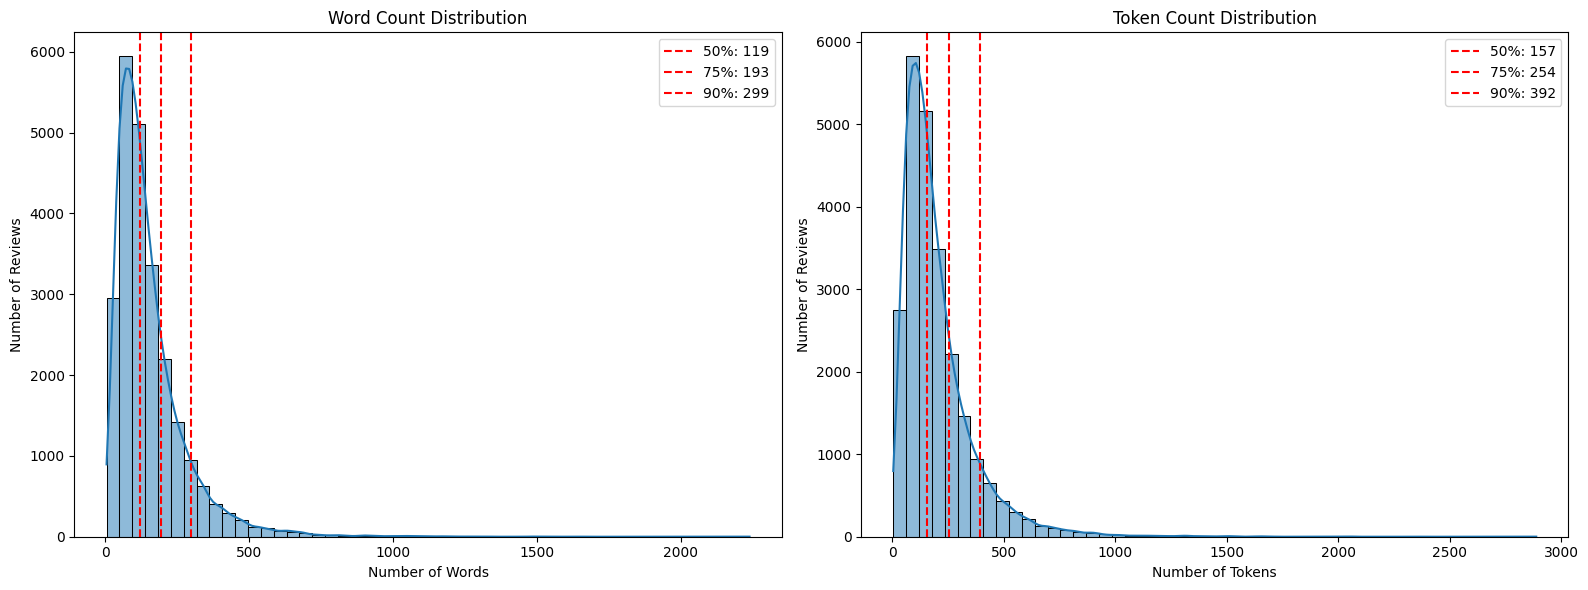

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5TokenizerFast

# Calculate number of words per review
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Load T5 tokenizer
tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# Compute token count
train_df['token_count'] = train_df['text'].apply(
    lambda x: len(tokenizer.encode(str(x), truncation=False)) if isinstance(x, str) and x.strip() else 0
)

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word count histogram with percentiles
sns.histplot(train_df['word_count'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Number of Reviews")
for p in [0.5, 0.75, 0.9]:
    val = train_df['word_count'].quantile(p)
    axes[0].axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')
axes[0].legend()

# Token count histogram with percentiles
sns.histplot(train_df['token_count'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Token Count Distribution")
axes[1].set_xlabel("Number of Tokens")
axes[1].set_ylabel("Number of Reviews")
for p in [0.5, 0.75, 0.9]:
    val = train_df['token_count'].quantile(p)
    axes[1].axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')
axes[1].legend()

plt.tight_layout()
plt.show()

Word and Token Count Distributions:

1.	Word Count Distribution: The median number of words per review is $117$, with $75%$ of reviews containing fewer than $189$ words and 90% fewer than $292$ words. The distribution is heavily right-skewed, indicating that most reviews are relatively short, with only a few exceeding $500$ words.

2.	Token Count Distribution: After tokenization using the T5 tokenizer, the median token count is $163$, with $75%$ of reviews under $262$ tokens and $90%$ under $402$ tokens. Overly long reviews can be safely truncated, while short ones may be padded to ensure consistency in batch processing.

3.	Fairness in Generation Length Settings: To ensure fair comparison between T5-small and GPT-2 in the generation task, both models are constrained to generate at most $128$ tokens. Specifically, T5-small uses max_length=$128$, while GPT-2 uses max_new_tokens=$128$, allowing both to produce comparable-length outputs. Given that 90% of the reviews are shorter than $402$ tokens, this limit captures most meaningful content. Additionally, GPT-2’s max_length during training is capped at $512$ to control the combined length of prompt and target, preventing memory overflow.

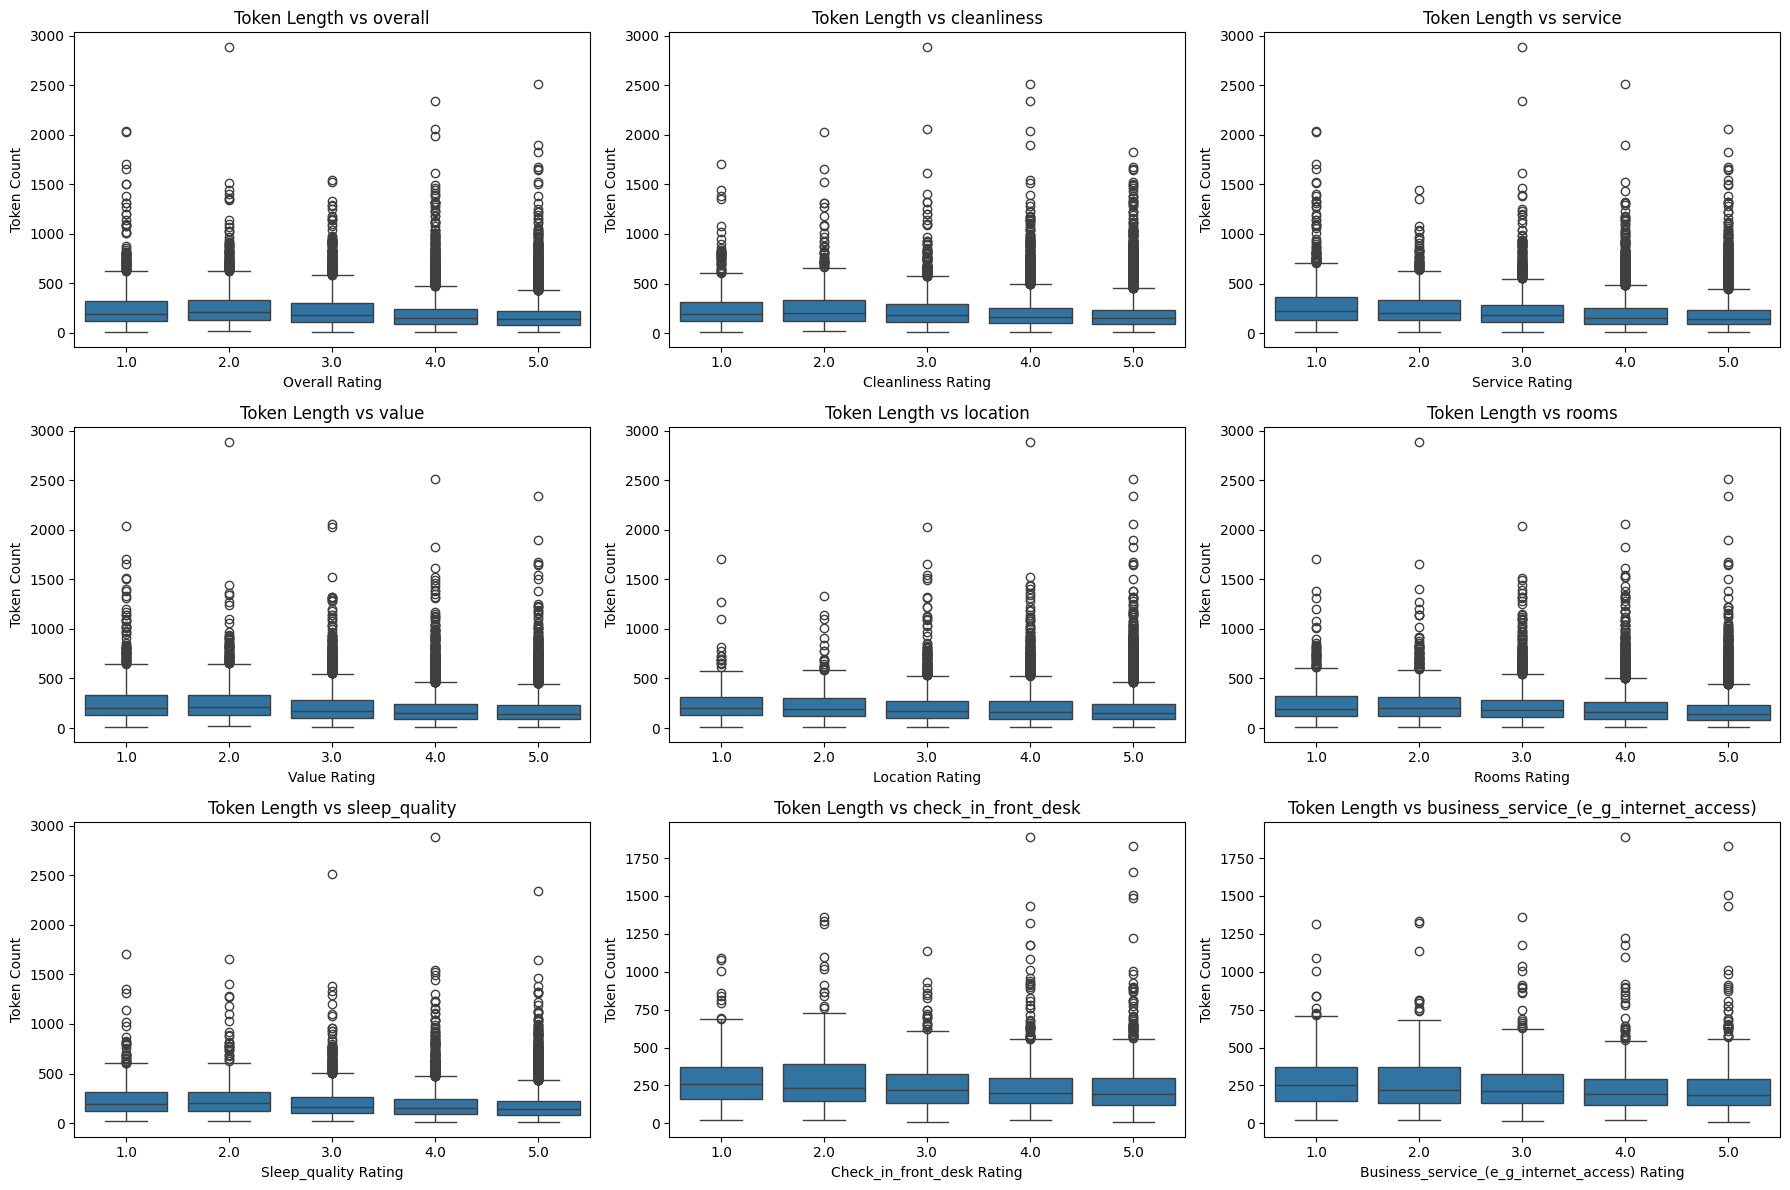

In [8]:
# Show token length per rating score via boxplot
# Create 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  

# Loop through each rating field
for ax, field in zip(axes.flatten(), rating_fields):
    if field in train_df.columns:
        sns.boxplot(x=field, y='token_count', data=train_df, ax=ax)
        ax.set_title(f'Token Length vs {field}')
        ax.set_xlabel(f'{field.capitalize()} Rating')
        ax.set_ylabel('Token Count')
    else:
        ax.set_visible(False) 

plt.tight_layout()
plt.show()

Relationship Between Ratings and Review Token Length:

1.	Overall consistency: Token length distributions remain relatively stable across ratings from $1$ to $5$. The interquartile ranges (IQR) are similar, and the medians show minimal variation, suggesting that review length is not strongly influenced by sentiment intensity.

2.	Presence of long-tail reviews: Outliers with significantly longer token counts exist at all rating levels, especially among 4- and 5-star reviews, indicating that highly satisfied users are more likely to write detailed comments.

3.	Slight increase in higher ratings: For certain aspects such as cleanliness, location, and rooms, reviews with a 5-star rating tend to be slightly longer, possibly reflecting the user’s motivation to elaborate on their positive experience.

4.	Rationale for fixed-length generation: While there is some variation in review length across rating levels, we enforce a fixed-length strategy by setting max_length=128 for T5-small and max_new_tokens=128 for GPT-2. This decision ensures consistency across models and evaluation scenarios, minimizing length-induced bias and supporting a fair comparison of generation quality.

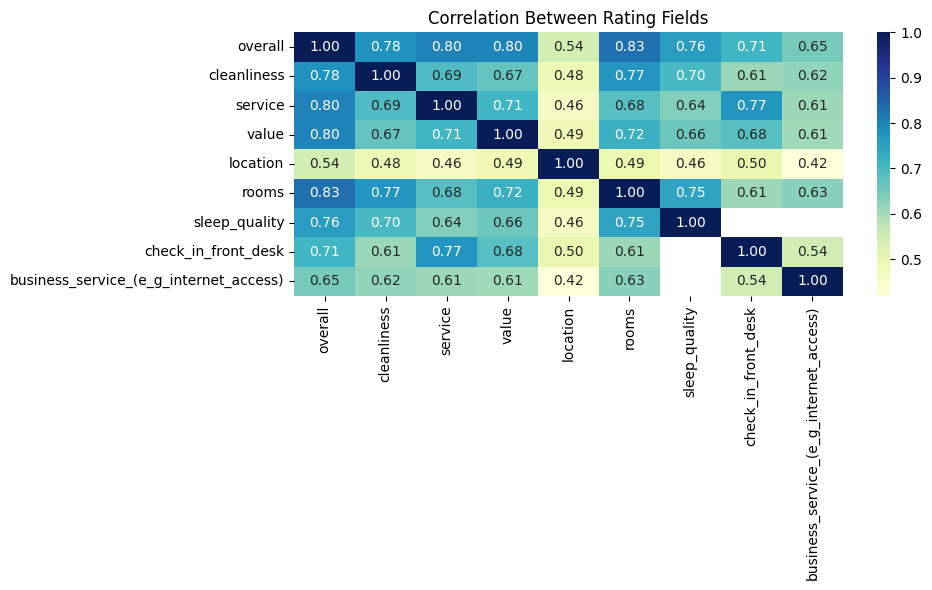

In [9]:
# Compute correlation between rating fields
plt.figure(figsize=(10, 6))
sns.heatmap(train_df[rating_fields].corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Between Rating Fields")
plt.tight_layout()
plt.show()

Correlation Analysis Between Rating Fields:

1.	Generally strong correlations: Most rating fields exhibit correlation coefficients above $0.6$, indicating a consistent rating pattern—users who rate one aspect highly often give high scores to other aspects as well.

2.	Fields strongly correlated with overall: The aspects most strongly correlated with overall are rooms ($0.83$), service ($0.80$), value ($0.80$), and cleanliness ($0.78$). This suggests that these factors contribute more heavily to a user’s overall impression. In contrast, location has a relatively low correlation ($0.54$), indicating it may be evaluated more independently or weigh less in overall satisfaction.

3.	Implications for prompt design and input selection: This correlation analysis offers practical guidance for constructing model input prompts. When not all rating fields can be included due to input length constraints, fields with stronger correlations to overall (e.g., rooms, service, value) should be prioritized to preserve the most influential information. Highly correlated fields may be merged or dimensionally reduced to minimize redundancy. Less correlated fields like location can be optionally excluded if they offer limited value to text generation quality, thereby improving model efficiency and input compactness.

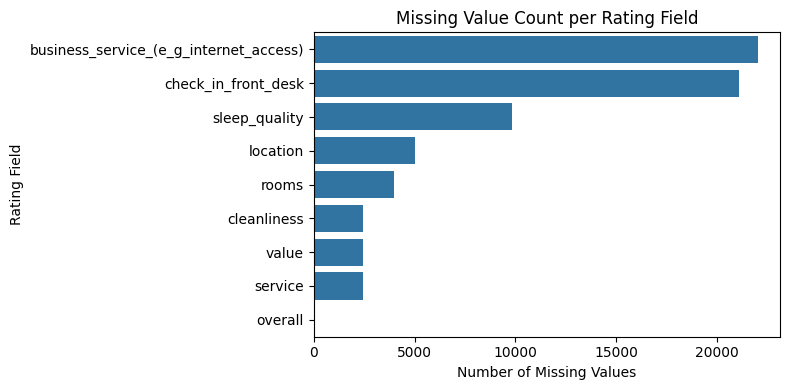

In [10]:
# Count missing values per rating field
missing_counts = train_df[rating_fields].isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_counts.values, y=missing_counts.index)
plt.title("Missing Value Count per Rating Field")
plt.xlabel("Number of Missing Values")
plt.ylabel("Rating Field")
plt.tight_layout()
plt.show()

Missing Value Analysis of Rating Fields:
	
1.	Highly sparse fields: business_service_(e_g_internet_access) and check_in_front_desk show the highest number of missing values—over $22,000$ and $21,000$ respectively—indicating that user ratings for these aspects are extremely rare in the dataset.
	
2.	Moderately missing fields: Fields such as sleep_quality (~$10,000$ missing) and location (~$5,000$ missing) also contain a notable amount of missing data, but they are significantly more complete than the two fields above and may still hold value for modeling.

3.	Relatively complete fields: Fields like overall, service, value, cleanliness, and rooms have fewer than $3,000$ missing entries and are largely complete. These can serve as the core components in prompt construction, providing reliable input features for the generation task.

4.	Implications for prompt construction: When building prompts for the model, it is advisable to dynamically include only the available rating fields while skipping the missing ones. This maximizes the use of each sample’s valid information and prevents discarding data unnecessarily. Highly sparse fields (e.g., business_service, check_in_front_desk) should be designed as optional segments in the prompt template to avoid occupying space when data is unavailable. Prioritizing complete fields improves training data coverage and supports model stability during learning.

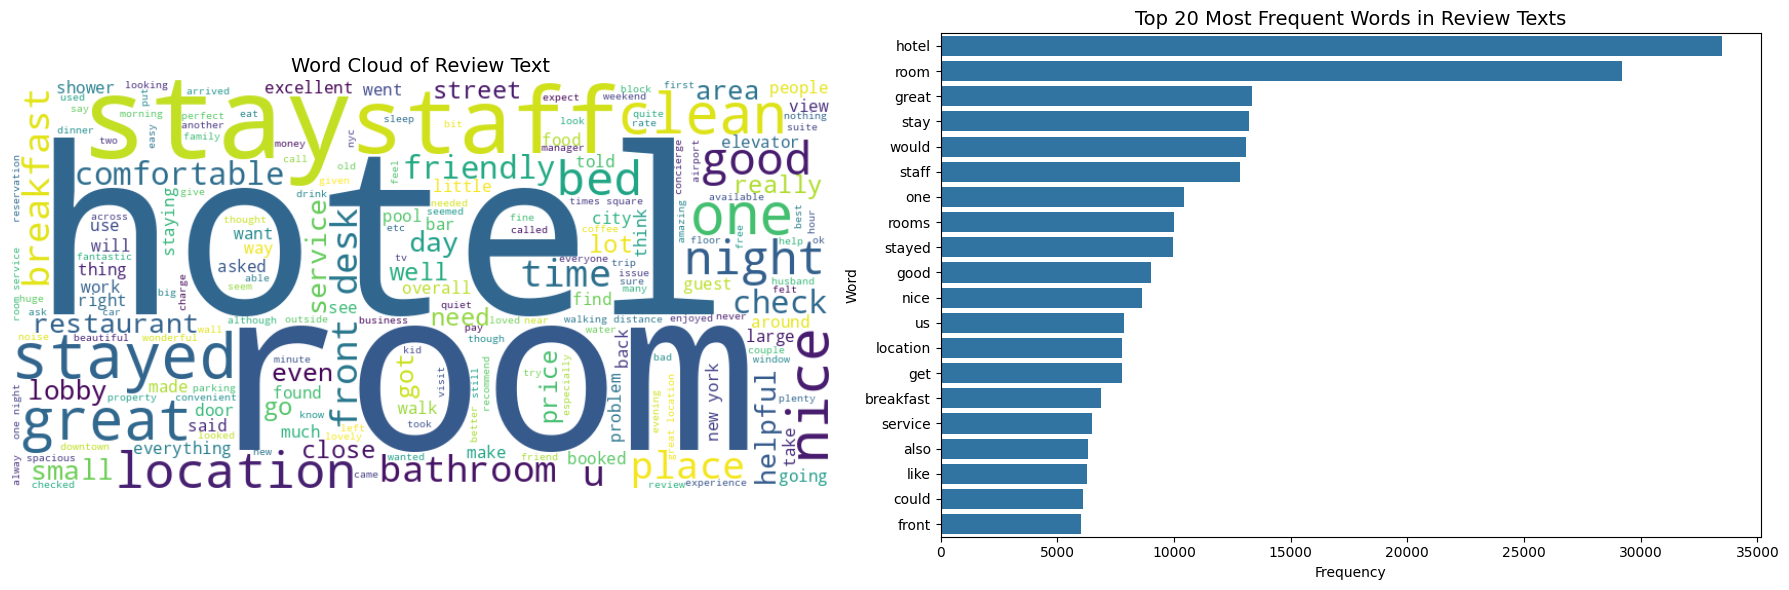

In [11]:
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Download English stopwords from NLTK
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Concatenate all reviews into a single string
all_text = " ".join(train_df['text'].dropna().tolist())

# Tokenize and convert to lowercase
word_list = all_text.lower().split()

# Remove stopwords and keep only alphabetic words
filtered_words = [word for word in word_list if word not in stop_words and word.isalpha() and len(word) > 1]

# Count word frequencies
word_freq = Counter(filtered_words)

# Convert the top 20 frequent words to a DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Create a 1-row 2-column visualization layout
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the word cloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud of Review Text", fontsize=14)

# Plot the word frequency bar chart
sns.barplot(x='Frequency', y='Word', data=freq_df, ax=axes[1])
axes[1].set_title('Top 20 Most Frequent Words in Review Texts', fontsize=14)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

plt.tight_layout()
plt.show()

Word Cloud and Frequency Statistics:

1.	Distribution of frequent words: As shown in the word cloud and bar chart, the most commonly used words in reviews include hotel, room, stay, staff, great, one, nice, clean, and location. These keywords represent the main aspects users care about—overall experience, room quality, service, and location.

2.	Dominance of positive sentiment: Words such as great, nice, good, and friendly appear frequently. Combined with the earlier observation of a right-skewed rating distribution, this confirms that the dataset is generally positive in tone.

3.	Presence of both content and structural words: Words like staff and room are content nouns, while stay, would, and get serve grammatical or structural roles. This indicates that the review style is conversational, subjective, and expressive.

4.	Implications for prompt design: These high-frequency words highlight common linguistic patterns in user reviews and can inspire more natural and contextually relevant prompt templates to guide text generation.

# 3. Selection and training Machine Learning models

## 3.1 Model-Oriented Data Preprocessing

In [12]:
from sklearn.model_selection import train_test_split

# Split the original training dataset into train and development datasets
train_set, dev_set = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

#Print the size of each split to verify
print(f"Train set size: {len(train_set)}") 
print(f"Dev set size: {len(dev_set)}")


Train set size: 19200
Dev set size: 4800


In [13]:
#Build a natural-language-style prompt
def build_prompt(row, model_type="t5"):

    def describe_score(field, score):
        # Provide semantic labels for scores, e.g., excellent/average/poor
        if score >= 4:
            return f"{field} was excellent ({score})"
        elif score <= 2:
            return f"{field} was poor ({score})"
        else:
            return f"{field} was average ({score})"

    # Define core and optional rating fields
    core_fields = ["overall", "cleanliness", "service", "value", "rooms"]
    optional_fields = ["location", "sleep_quality"]

    rating_strs = []
    for field in core_fields + optional_fields:
        score = row.get(field)
        if pd.notna(score):
            # Convert scores to natural language expressions and add to the list
            rating_strs.append(describe_score(field.replace('_', ' '), score))


    # Build additional context information such as date, source, etc.
    context_parts = []
    if pd.notna(row.get("date_stayed")):
        context_parts.append(f"date stayed: {row['date_stayed']}")
    if pd.notna(row.get("via_mobile")):
        context_parts.append(f"via mobile: {row['via_mobile']}")
    if pd.notna(row.get("num_helpful_votes")) and row['num_helpful_votes'] > 0:
        context_parts.append(f"marked helpful by {row['num_helpful_votes']} users")
    if isinstance(row.get("author"), dict):
        location = row["author"].get("location", "")
        if pd.notna(location) and location != "":
            context_parts.append(f"guest location: {location}")


    # Format prompt based on model type (T5 or GPT-2)
    if model_type == "t5":
        # T5-style: task-specific instruction prompt
        prompt = ""
        if rating_strs:
            prompt += "The guest gave the following feedback: " + "; ".join(rating_strs) + "."
        if context_parts:
            prompt += " Additional context: " + ", ".join(context_parts) + "."
        prompt += " Based on this information, write a possible text:"

    elif model_type == "gpt2":
        # GPT-2-style: simulate continuation from context
        prompt = ""
        if rating_strs:
            prompt += "A customer gave these ratings: " + "; ".join(rating_strs) + "."
        if context_parts:
            prompt += " Context: " + ", ".join(context_parts) + "."
        prompt += " Here's a possible review they might have written: "

    else:

        raise ValueError("Unsupported model_type. Choose 't5' or 'gpt2'.")

    return prompt

In [14]:
train_set["input_prompt"] = train_set.apply(lambda row: build_prompt(row, model_type="t5"), axis=1)
dev_set["input_prompt"] = dev_set.apply(lambda row: build_prompt(row, model_type="t5"), axis=1)

In [ ]:
from transformers import T5Tokenizer
# 1. T5-small: token

# Load T5 tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokenization function
def tokenize_t5(sample):
    input_encoding = t5_tokenizer(
        sample['input_prompt'],
        padding="max_length",        # pad to max length
        truncation=True,             # truncate if too long
        max_length=512,
        return_tensors="pt"          # return PyTorch tensors
    )

    target_encoding = t5_tokenizer(
        sample['text'],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = target_encoding.input_ids.squeeze(0)
    labels[labels == t5_tokenizer.pad_token_id] = -100

    return {
        "input_ids": input_encoding.input_ids.squeeze(),         # remove batch dim
        "attention_mask": input_encoding.attention_mask.squeeze(),
        "labels": labels
    }


#https://www.kaggle.com/code/vinitkp/text-to-text-transfer-transformer
#https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [42]:
from transformers import GPT2Tokenizer

# Load GPT-2 tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  # Important for padding support

# Tokenization function
def tokenize_gpt2(sample):
    full_input = sample['input_prompt'] + " " + sample['text']

    encoding = gpt2_tokenizer(
        full_input,
        padding="max_length",         
        truncation=True,             
        max_length=512,  # (prompt + text)
        return_tensors="pt"
    )

    input_ids = encoding.input_ids.squeeze()
    attention_mask = encoding.attention_mask.squeeze()
    
    labels = input_ids.clone()
    labels[input_ids == gpt2_tokenizer.pad_token_id] = -100

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": input_ids
    }


#https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Tokenizer


## 3.2 Define evaluation metric functions

In [17]:
# 1. General Evaluation Metrics-rouge

from rouge_score import rouge_scorer

def compute_rouge_f1(predictions, references):

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_f1 = []
    rouge2_f1 = []
    rougel_f1 = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_f1.append(scores['rouge1'].fmeasure)
        rouge2_f1.append(scores['rouge2'].fmeasure)
        rougel_f1.append(scores['rougeL'].fmeasure)

    return {
        "ROUGE-1 F1": sum(rouge1_f1) / len(rouge1_f1),
        "ROUGE-2 F1": sum(rouge2_f1) / len(rouge2_f1),
        "ROUGE-L F1": sum(rougel_f1) / len(rougel_f1)
    }

#https://github.com/google-research/google-research/tree/master/rouge
#https://lightning.ai/docs/torchmetrics/stable/text/rouge_score.html


In [18]:
# 2. Word-Level Semantic Similarity-Greedy Word Embedding Matching
import gensim.downloader as api

# Download and load pre-trained GloVe 300-dimensional word vectors
word_vectors = api.load("glove-wiki-gigaword-300")

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def greedy_matching_score(ref_tokens, pred_tokens, word_vectors):
    """
    Compute the Greedy Word Embedding Matching score (word-level semantic similarity) between two token lists.

    Args:
        ref_tokens (List[str]):Tokenized reference text (ground truth)
        pred_tokens (List[str]): Tokenized predicted/generated text
        word_vectors (gensim KeyedVectors):Pre-trained word embedding model 

    Returns:
        float: Greedy matching similarity score (between 0 and 1, higher means more semantically similar)
    """

    def get_vectors(tokens):
        # Get vectors for all tokens that exist in the word embedding model
        return np.array([word_vectors[word] for word in tokens if word in word_vectors])

    vec_ref = get_vectors(ref_tokens)
    vec_pred = get_vectors(pred_tokens)

    # Return 0.0 if no valid embeddings are found in either sentence
    if len(vec_ref) == 0 or len(vec_pred) == 0:
        return 0.0

    # Compute cosine similarity matrix between predicted and reference vectors
    sim_matrix = cosine_similarity(vec_pred, vec_ref)

    # For each predicted word, find the most similar reference word
    max_pred_to_ref = np.mean(np.max(sim_matrix, axis=1))

    # For each reference word, find the most similar predicted word
    max_ref_to_pred = np.mean(np.max(sim_matrix, axis=0))

    # Final score is the average of both directions
    return (max_pred_to_ref + max_ref_to_pred) / 2


#https://arxiv.org/pdf/1603.08023

In [19]:
# 3. Sentence-Level Semantic Similarity-BERTScore
from bert_score import score

def compute_bertscore(predictions, references, lang="en"):
    """
    Compute average BERTScore precision, recall, and F1.
    """
    P, R, F1 = score(predictions, references, lang=lang)
    return {
        'bertscore_precision': P.mean().item(),
        'bertscore_recall': R.mean().item(),
        'bertscore_f1': F1.mean().item()
    }

#https://github.com/Tiiiger/bert_score/blob/master/example/Demo.ipynb
#https://arxiv.org/abs/1904.09675

In [20]:
# 4. Combined Semantic Evaluation
def combined_semantic_score(greedy_score, bert_f1_score, alpha=0.3):
    """
    Combine word-level and sentence-level semantic scores using weighted average.

    Args:
        greedy_score (float): Greedy word embedding matching score
        bert_f1_score (float): BERTScore F1
        alpha (float): Weight for greedy score (0 <= alpha <= 1)

    Returns:
        float: Combined semantic similarity score
    """
    return alpha * greedy_score + (1 - alpha) * bert_f1_score

In [21]:
# 5. Define the evaluate all metrics function 
import pandas as pd
from tqdm import tqdm

def evaluate_all_metrics(preds, refs, word_vectors):
    # 1. ROUGE
    rouge = compute_rouge_f1(preds, refs)

    # 2. Greedy Matching (word-level semantic)
    greedy_scores = [
        greedy_matching_score(ref.split(), pred.split(), word_vectors)
        for ref, pred in zip(refs, preds)
    ]
    greedy = sum(greedy_scores) / len(greedy_scores)

    # 3. BERTScore
    bert = compute_bertscore(preds, refs)
    bert_f1 = bert['bertscore_f1']

    # 4. Combined Score
    combined = combined_semantic_score(greedy, bert_f1)

    return {
        **rouge,
        'greedy_score': greedy,
        **bert,
        'combined_score': combined
    }

# 4. Model Fine-Tuning and Hyperparameter Selection (T5 and GPT-2)

## 4.1 T5-Small model

In [40]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd

# Custom Dataset class for tokenizing each row
class T5FineTuneDataset(Dataset):
    def __init__(self, dataframe, tokenizer_func):
        self.dataframe = dataframe
        self.tokenizer_func = tokenizer_func

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        return self.tokenizer_func(sample)

#  Training + validation for a single hyperparameter config
def run_single_t5_training(train_df, val_df, tokenizer_func, learning_rate=5e-5, batch_size=8, num_epochs=3):
    
    #Set device: use GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

    # Load train and validation sets
    train_dataset = T5FineTuneDataset(train_df, tokenizer_func)
    val_dataset = T5FineTuneDataset(val_df, tokenizer_func)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    # Set optimizer and LR scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0,
        num_training_steps=len(train_loader) * num_epochs
    )

    # Containers to store average training and development losses per epoch
    train_losses = []  # Store average loss for each epoch
    dev_losses=[]

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            # Move batch data to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Calculate and record average training loss
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch+1}] Avg Training Loss: {avg_train_loss:.4f}")

        # Evaluation phase: calculate validation loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                total_val_loss += outputs.loss.item()

        # Calculate and record average validation loss
        avg_val_loss = total_val_loss / len(val_loader)
        dev_losses.append(avg_val_loss)
        print(f"[Epoch {epoch+1}] Avg Dev Loss: {avg_val_loss:.4f}")
        
        import sys
        sys.stdout.flush()
        
        model.train()  # Switch back to training mode


    # Prediction on validation set after training
    model.eval()
    predictions, references = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=128)
            pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            ref = tokenizer.decode(labels[0], skip_special_tokens=True)

            predictions.append(pred)
            references.append(ref)

    # Return predictions, references, and loss histories
    return predictions, references, train_losses, dev_losses, model

#https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb
#https://huggingface.co/docs/transformers/model_doc/t5


In [41]:
# Grid search multiple hyperparameter configs
def run_grid_search(train_df, val_df, tokenizer_func, word_vectors,output_csv="all_results.csv"):

    # Hyperparameter options
    learning_rates = [5e-5, 1e-4] 
    batch_sizes = 2                    
    num_epochs = 3                     
    
    results = []     
    loss_logs = []  
    
    # Initialize variables for saving best model
    best_combined = -1.0  
    best_model = None    
    best_tokenizer = None 
    best_config = {}
    
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    
    # Iterate over each learning rate configuration
    for lr in learning_rates:
        print(f"\nRunning config: learning_rate={lr}")

        # Run training and get predictions, references, and losses
        predictions, references, train_losses, dev_losses,model = run_single_t5_training(
            train_df=train_df,
            val_df=val_df,
            tokenizer_func=tokenizer_func,
            learning_rate=lr,
            batch_size=batch_sizes,
            num_epochs=num_epochs
        )

        # Evaluate predictions using external metric function
        metrics = evaluate_all_metrics(predictions, references, word_vectors)


        # Store result for comparison
        result = {
            "learning_rate": lr,
            "batch_size": batch_sizes,
            "num_epochs": num_epochs,
            **metrics  
        }
        results.append(result)

        # Store training and dev loss for plotting later
        loss_logs.append({
            "learning_rate": lr,
            "train_losses": train_losses,
            "dev_losses": dev_losses
        })
        
        # Check if this is the best model so far based on combined_score
        if metrics["combined_score"] > best_combined:
            best_combined = metrics["combined_score"]
            best_config = {
                "learning_rate": lr,
                "batch_size": batch_sizes,
                "num_epochs": num_epochs
            }
            print(f"New best model found with combined_score = {best_combined:.4f}")
            model.save_pretrained("best_model_t5")
            tokenizer.save_pretrained("best_model_t5")


    # Save all evaluation results to a CSV file for review
    df_results = pd.DataFrame(results)
    try:
        df_results.to_csv(output_csv, mode='a', index=False, header=not pd.read_csv(output_csv).empty)
    except FileNotFoundError:
        df_results.to_csv(output_csv, index=False)

    print(f"\nAll results saved to {output_csv}")


    # Print the best model configuration summary
    print("\nBest Model Config:")
    for k, v in best_config.items():
        print(f"{k}: {v}") 


    return df_results, loss_logs

In [32]:
results_t5, loss_logs_t5 = run_grid_search(
    train_df=train_set,
    val_df=dev_set,
    tokenizer_func=tokenize_t5,
    word_vectors=word_vectors,
    output_csv="all_results.csv"
)


Running config: learning_rate=5e-05


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Epoch 1: 100%|██████████| 9600/9600 [12:50<00:00, 12.46it/s]


[Epoch 1] Avg Training Loss: 3.1784
[Epoch 1] Avg Dev Loss: 2.9150


Epoch 2: 100%|██████████| 9600/9600 [12:48<00:00, 12.50it/s]


[Epoch 2] Avg Training Loss: 3.0331
[Epoch 2] Avg Dev Loss: 2.8657


Epoch 3: 100%|██████████| 9600/9600 [12:50<00:00, 12.46it/s]


[Epoch 3] Avg Training Loss: 2.9928
[Epoch 3] Avg Dev Loss: 2.8527


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New best model found with combined_score = 0.8170


Exception ignored in: <function tqdm.__del__ at 0x7ee8301b1990>
Traceback (most recent call last):
  File "/opt/conda/Anaconda3/envs/nlp-small/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/conda/Anaconda3/envs/nlp-small/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'



Running config: learning_rate=0.0001


Epoch 1: 100%|██████████| 9600/9600 [12:21<00:00, 12.94it/s]


[Epoch 1] Avg Training Loss: 3.1155
[Epoch 1] Avg Dev Loss: 2.8605


Epoch 2: 100%|██████████| 9600/9600 [12:19<00:00, 12.99it/s]


[Epoch 2] Avg Training Loss: 2.9596
[Epoch 2] Avg Dev Loss: 2.8051


Epoch 3: 100%|██████████| 9600/9600 [12:17<00:00, 13.01it/s]


[Epoch 3] Avg Training Loss: 2.9100
[Epoch 3] Avg Dev Loss: 2.7898


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New best model found with combined_score = 0.8193

All results saved to all_results.csv

Best Model Config:
learning_rate: 0.0001
batch_size: 2
num_epochs: 3


## 4.2 GPT-2 model

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd

# Custom Dataset class for GPT-2 tokenization
class GPT2FineTuneDataset(Dataset):
    def __init__(self, dataframe, tokenizer_func):
        self.dataframe = dataframe
        self.tokenizer_func = tokenizer_func

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        return self.tokenizer_func(sample)

# Training + validation function for GPT-2
def run_single_gpt2_training(train_df, val_df, tokenizer_func, tokenizer,
                              learning_rate=5e-5, batch_size=4, num_epochs=3):
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load GPT-2 model and resize token embeddings
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    model.resize_token_embeddings(len(tokenizer))
    model = model.to(device)

    # Load train and validation data
    train_dataset = GPT2FineTuneDataset(train_df, tokenizer_func)
    val_dataset = GPT2FineTuneDataset(val_df, tokenizer_func)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=0,
        num_training_steps=len(train_loader) * num_epochs
    )


    # Loss tracking
    train_losses = []
    dev_losses = []

    # Start training
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0

        # Training for each batch
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch+1}] Avg Training Loss: {avg_train_loss:.4f}")

        # Validation phase (using development set) to compute loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                total_val_loss += outputs.loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        dev_losses.append(avg_val_loss)
        print(f"[Epoch {epoch+1}] Avg Dev Loss: {avg_val_loss:.4f}")
        
        import sys
        sys.stdout.flush()
        
        model.train()

    # Inference for predictions vs references
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            output_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=128,pad_token_id=gpt2_tokenizer.pad_token_id )
            pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            ref = tokenizer.decode(input_ids[0], skip_special_tokens=True)

            predictions.append(pred)
            references.append(ref)


    # Return predictions, references, training loss, and dev loss
    return predictions, references, train_losses, dev_losses, model

In [44]:
# Grid search multiple hyperparameter configs for GPT-2
def run_grid_search_gpt2(train_df, val_df, tokenizer_func, tokenizer, word_vectors,output_csv="all_results.csv"):

    # Define hyperparameter ranges
    learning_rates = [5e-5, 1e-4]
    batch_sizes = 2
    num_epochs = 3

    results = []      
    loss_logs = []    

    # Initialize variables for saving best model
    best_combined = -1.0
    best_model = None
    best_tokenizer = None
    best_config = {}

    for lr in learning_rates:
        print(f"\n Running config: learning_rate={lr}")

        # Run training and get predictions, references, and loss history
        predictions, references, train_losses, dev_losses,model = run_single_gpt2_training(
            train_df=train_df,
            val_df=val_df,
            tokenizer_func=tokenizer_func,
            tokenizer=tokenizer,
            learning_rate=lr,
            batch_size=batch_sizes,
            num_epochs=num_epochs
        )

        # Evaluate predictions using external metric function
        metrics = evaluate_all_metrics(predictions, references, word_vectors)


        # Store current configuration result
        result = {
            "learning_rate": lr,
            "batch_size": batch_sizes,
            "num_epochs": num_epochs,
            **metrics
        }
        results.append(result)

        # Store loss logs for visualization
        loss_logs.append({
            "learning_rate": lr,
            "train_losses": train_losses,
            "dev_losses": dev_losses
        })
        # If this is the best model, save it
        if metrics["combined_score"] > best_combined:
            print(f"New best model found with combined_score = {metrics['combined_score']:.4f}")
            best_combined = metrics["combined_score"]

            # Save clean tokenizer & model
            model.save_pretrained("best_model_gpt2") 
            tokenizer.save_pretrained("best_model_gpt2")

            best_config = {
                "learning_rate": lr,
                "batch_size": batch_sizes,
                "num_epochs": num_epochs
            }

    # CSV Save all results to CSV
    df_results = pd.DataFrame(results)
    try:
        df_results.to_csv(output_csv, mode='a', index=False, header=not pd.read_csv(output_csv).empty)
    except FileNotFoundError:
        df_results.to_csv(output_csv, index=False)
        
    print(f"\nAll results saved to {output_csv}")

    # Print best configuration
    print("\nBest Model Config:")
    for k, v in best_config.items():
        print(f"{k}: {v}")


    # Return metrics and loss logs
    return df_results, loss_logs

In [45]:
results_gpt2, loss_logs_gpt2 = run_grid_search_gpt2(
    train_df=train_set,
    val_df=dev_set,
    tokenizer_func=tokenize_gpt2,
    tokenizer=gpt2_tokenizer,
    word_vectors=word_vectors,
    output_csv="all_results.csv"
    
)


 Running config: learning_rate=5e-05


Epoch 1: 100%|██████████| 9600/9600 [08:45<00:00, 18.26it/s]


[Epoch 1] Avg Training Loss: 1.1752
[Epoch 1] Avg Dev Loss: 1.1110


Epoch 2: 100%|██████████| 9600/9600 [08:42<00:00, 18.38it/s]


[Epoch 2] Avg Training Loss: 1.0823
[Epoch 2] Avg Dev Loss: 1.0907


Epoch 3: 100%|██████████| 9600/9600 [08:47<00:00, 18.19it/s]


[Epoch 3] Avg Training Loss: 1.0410
[Epoch 3] Avg Dev Loss: 1.0858


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New best model found with combined_score = 0.9999

 Running config: learning_rate=0.0001


Epoch 1: 100%|██████████| 9600/9600 [08:41<00:00, 18.41it/s]


[Epoch 1] Avg Training Loss: 1.1705
[Epoch 1] Avg Dev Loss: 1.1090


Epoch 2: 100%|██████████| 9600/9600 [08:48<00:00, 18.17it/s]


[Epoch 2] Avg Training Loss: 1.0585
[Epoch 2] Avg Dev Loss: 1.0850


Epoch 3: 100%|██████████| 9600/9600 [08:38<00:00, 18.51it/s]


[Epoch 3] Avg Training Loss: 0.9954
[Epoch 3] Avg Dev Loss: 1.0821


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


New best model found with combined_score = 0.9999

All results saved to all_results.csv

Best Model Config:
learning_rate: 0.0001
batch_size: 2
num_epochs: 3


## 4.3 Validation-Based Evaluation and Model Selection

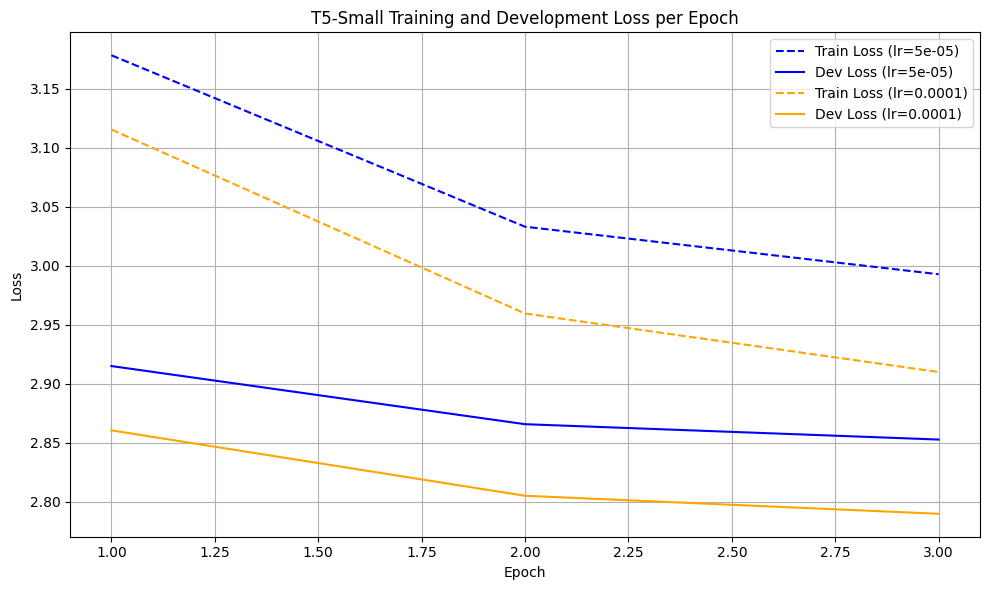

In [57]:
import matplotlib.pyplot as plt

# T5-small training & dev loss visualization
def plot_loss_curves(loss_logs):
    # Create a figure with specified size
    plt.figure(figsize=(10, 6))
    
    # Set up colors
    colors = ['blue', 'orange']
    lr_to_color = {}  
    color_idx = 0
    
    # Iterate over each hyperparameter config's loss logs
    for log in loss_logs:
        lr = log['learning_rate']  
        train_losses = log['train_losses'] 
        dev_losses = log['dev_losses']     
        epochs = list(range(1, len(train_losses) + 1))  
        
        #Assign colors
        if lr not in lr_to_color:
            lr_to_color[lr] = colors[color_idx]
            color_idx += 1

        color = lr_to_color[lr]
        
        # Plot training loss curve (dashed line)
        plt.plot(epochs, train_losses, label=f"Train Loss (lr={lr})", linestyle='--', color=color)
        # Plot dev loss curve (solid line)
        plt.plot(epochs, dev_losses, label=f"Dev Loss (lr={lr})", linestyle='-', color=color)

    # Set labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("T5-Small Training and Development Loss per Epoch")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("loss_curves_t5.png")
    plt.show()

# Call the plotting function
plot_loss_curves(loss_logs_t5)

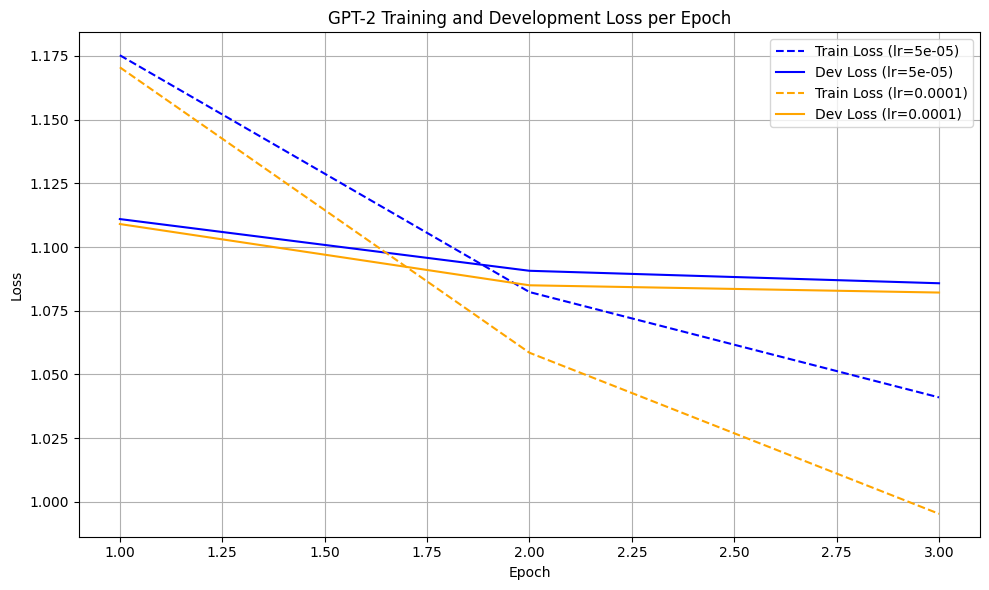

In [58]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# GPT-2 training & dev loss visualization
def plot_loss_curves_gpt2(loss_logs):

    plt.figure(figsize=(10, 6))
    
    # Set up colors
    colors = ['blue', 'orange']
    lr_to_color = {}  
    color_idx = 0

    # Iterate over each hyperparameter config's loss logs
    for log in loss_logs:
        lr = log['learning_rate']  
        train_losses = log['train_losses'] 
        dev_losses = log['dev_losses']      
        epochs = list(range(1, len(train_losses) + 1)) 
        
        #Assign colors
        if lr not in lr_to_color:
            lr_to_color[lr] = colors[color_idx]
            color_idx += 1

        color = lr_to_color[lr]

        # Plot training loss curve (dashed line)
        plt.plot(epochs, train_losses, label=f"Train Loss (lr={lr})", linestyle='--', color=color)
        
        # Plot dev loss curve (solid line)
        plt.plot(epochs, dev_losses, label=f"Dev Loss (lr={lr})", linestyle='-', color=color)

    # Set labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GPT-2 Training and Development Loss per Epoch")
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.savefig("loss_curves_gpt2.png")
    plt.show()


# Call the plotting function
plot_loss_curves_gpt2(loss_logs_gpt2)

# 5. Final Model Selection and Test Set Evaluation

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the best saved GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("best_model_gpt2")
model = GPT2LMHeadModel.from_pretrained("best_model_gpt2")
model.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Build prompts for GPT-2-style input
test_df["prompt"] = test_df.apply(lambda row: build_prompt(row, model_type="gpt2"), axis=1)

###
# Generate reviews based on the prompts
generated_reviews_gpt2 = []
for prompt in tqdm(test_df["prompt"], desc="Generating GPT-2 reviews"):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(**inputs, max_length=100)
    review = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_reviews_gpt2.append(review)


# Store generated reviews in a new column
test_df["generated_review_gpt2"] = generated_reviews_gpt2


# Get reference texts and generated reviews
references = test_df["text"].tolist()
predictions = test_df["generated_review_gpt2"].tolist()


# Evaluate all metrics
gpt2_metrics = evaluate_all_metrics(predictions, references, word_vectors)

# Print results
print("\nGPT-2 Test Set Metrics:")
for k, v in gpt2_metrics.items():
    print(f"{k}: {v:.4f}")

# 6. User Interface Implementation

In [ ]:
#User Interface coding
while True:
    
    # Prompt user
    print("Welcome! You can generate a review by entering a review_id from the test set.")
    review_id = input("Please enter review_id: ").strip()

    if review_id.lower() == 'exit':
        print('Goodbye!')
        break
    
    # Check existence
    if review_id not in test_df.index:
        print(f"Error: review_id '{review_id}' not found in test set. Please try again.")
        continue_or_exit = input("Do you want to try another review_id? (y/n): ").strip().lower()
        if continue_or_exit != 'y':
            break  # exit the loop
        continue  # go back to input prompt
    else:
        break  


# Retrieve the corresponding row and build prompt
row = test_df.loc[review_id]
prompt = build_prompt(row, model_type='t5')


# Tokenize the input prompt for the model
inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(device)


# Use the model to generate the review text
try:
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_length=100)
        output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"\nPredicted review text for review_id '{review_id}':\n{output}")
except Exception as e:
    print(f"Generation failed: {e}")

# References

1. Lin, C.-Y. (2004). ROUGE: A Package for Automatic Evaluation of Summaries. In Text Summarization Branches Out: Proceedings of the ACL-04 Workshop (pp. 74–81). Barcelona, Spain.

# Appendix

## Two contrasting versions of the build_prompt function template

In [54]:
# Basic prompt
def build_prompt_basic(row):
    rating_fields = ["overall", "cleanliness", "service", "value", "location", "rooms", 
                     "sleep_quality", "check_in_front_desk", "business_service_(e_g_internet_access)"]
    parts = []
    for field in rating_fields:
        if pd.notna(row.get(field)):
            parts.append(f"{field}={row[field]}")

    prompt = "generate review given ratings: " + ", ".join(parts) + ". text:"
    return prompt

In [55]:
#  Natural language style prompt
def build_prompt_natural(row):
    parts = []

    def add(field, label):
        val = row.get(field)
        if pd.notna(val):
            parts.append(f"{label} rating was {val}")

    add("overall", "overall")
    add("cleanliness", "cleanliness")
    add("service", "staff/service")
    add("value", "value for money")
    add("location", "location")
    add("rooms", "room quality")
    add("sleep_quality", "sleep quality")
    add("check_in_front_desk", "check-in experience")
    add("business_service_(e_g_internet_access)", "internet/business service")

    if parts:
        ratings_str = "; ".join(parts)
        return f"The guest gave the following feedback: {ratings_str}. Based on this, generate a possible review:"
    else:
        return "The guest left no rating. Generate a general review:"

In [56]:
train_df["prompt_basic"] = train_df.apply(build_prompt_basic, axis=1)
train_df["prompt_natural"] = train_df.apply(build_prompt_natural, axis=1)